In [1]:
import os
import sys
import uproot
import peakutils

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

from scipy.signal import savgol_filter

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('/Users/romoluque_c/Repositories/BACON_romo/') ## Choose right path
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
plt.rcParams["figure.figsize"] = 9, 6
plt.rcParams["font.size"]      = 14

In [4]:
import matplotlib

# Set Palatino as the serif font
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif']  = 'Palatino'

In [5]:
fav_col = '#418094'

## Load file example:

In [6]:
filename = '/Users/romoluque_c/LEGEND/BACON/new_setup/datatest/run-09_10_2024-file_10.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

#### Plot one event:

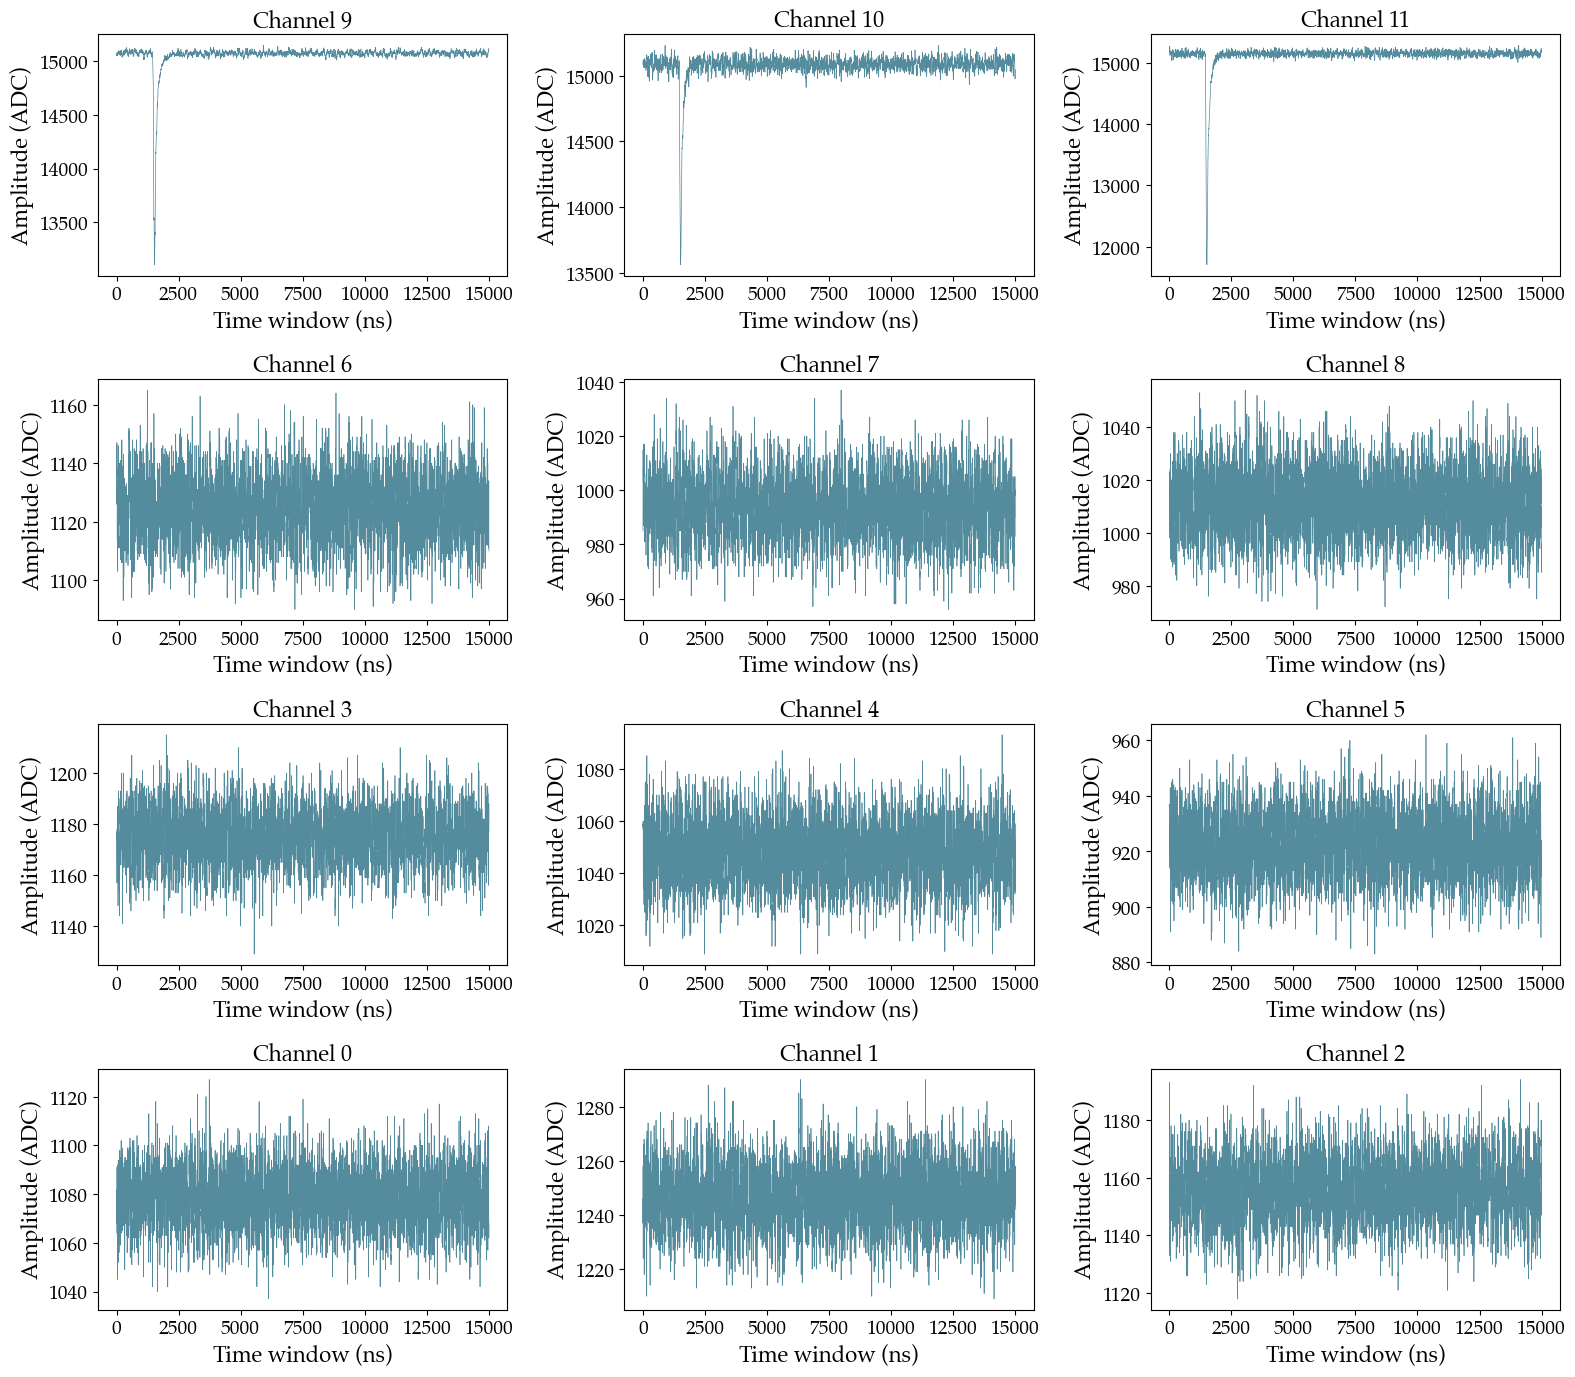

In [7]:
sel_evt  = 0
fig, axs = plt.subplots(4, 3, figsize=(16, 14))
for row, ich in enumerate(reversed(np.arange(0, 12, 3))):
    for col in range(3):
        ch = ich + col
        wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[sel_evt]
        axs[row][col].plot(2*np.arange(len(wf)), wf, linewidth=0.5, color=fav_col, alpha=0.9)
        axs[row][col].set_xlabel('Time window (ns)', fontsize=16)
        axs[row][col].set_ylabel('Amplitude (ADC)',  fontsize=16)
        axs[row][col].set_title(f"Channel {ch}",     fontsize=16)
plt.tight_layout()
plt.show()

#### The trigger SiPMs always have signal (and it is negative due to their electronics), whereas the other SiPMs not always detect peaks (when this happens, only baseline is observed).

#### Let's look for an event with peaks in several SiPMs:

In [8]:
### Get the events with signal using the standard deviation:

all_chs_good_evts = []
for ch in range(9):
    all_chs_good_evts.append(np.where(np.std(np.array(RawTree[f'chan{ch}/rdigi'].array()), axis=1)>13)[0])
    

### Get the common good events to plot an event with multiple peaks

common_good_evts = set(all_chs_good_evts[0])
for ch_good_evts in [all_chs_good_evts[3], all_chs_good_evts[6]]:
    common_good_evts = set(all_chs_good_evts[0]).intersection(ch_good_evts)

common_good_evts = list(common_good_evts)

print("Common good events across channels:", common_good_evts)

Common good events across channels: [4354, 15618, 12805, 5511, 1674, 19338, 20746, 5015, 7576, 18072, 19735, 14110, 10019, 15910, 16167, 2602, 2091, 13950, 18350, 13746, 15411, 6068, 9141, 14774, 2359, 17464, 14009, 11836, 4542, 19323, 7364, 3014, 14791, 10187, 6732, 7244, 11340, 18765, 2513, 6610, 11093, 6358, 2648, 473, 2905, 4443, 8027, 9949, 14433, 1253, 13669, 13926, 3306, 12650, 3566, 13936, 2804, 7289, 9595, 19709, 4862, 15615]


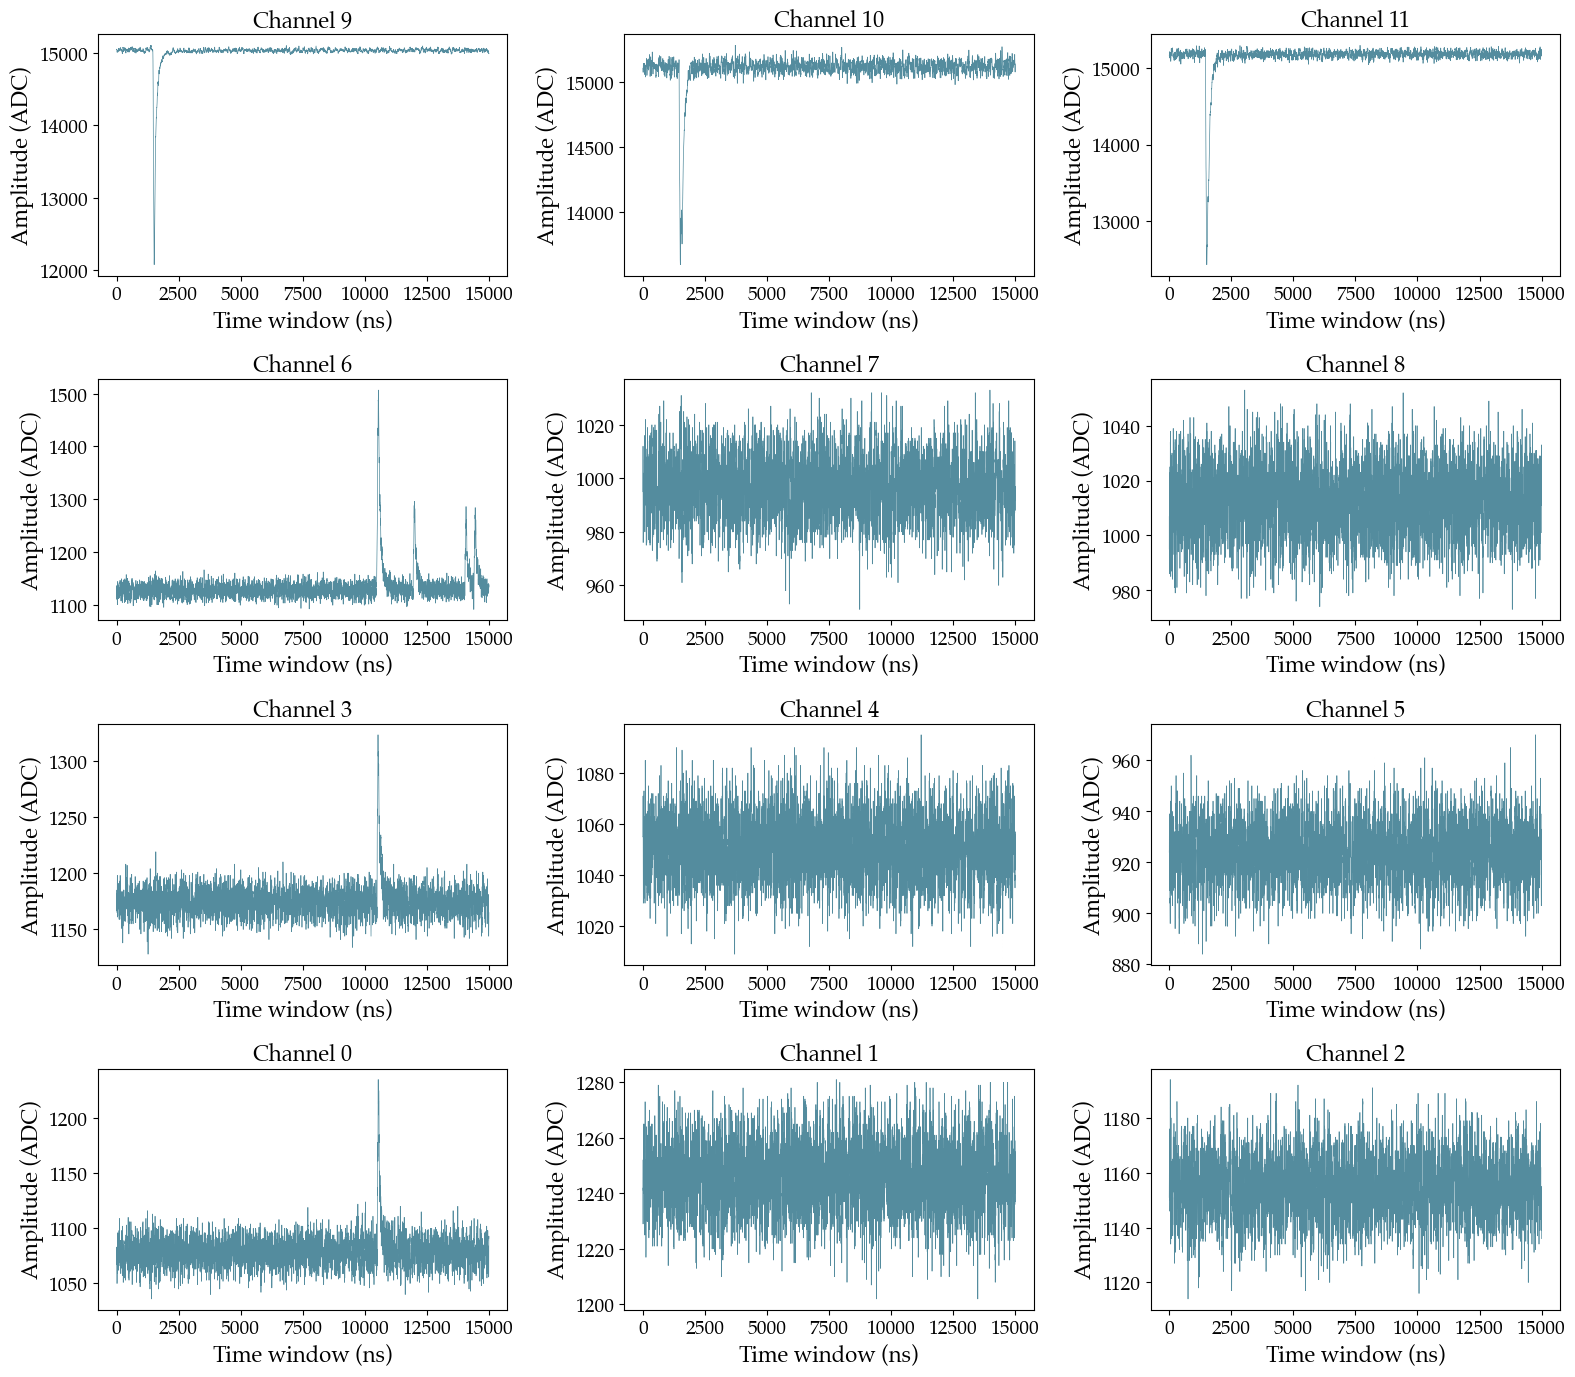

In [9]:
sel_evt  = 4354
fig, axs = plt.subplots(4, 3, figsize=(16, 14))
for row, ich in enumerate(reversed(np.arange(0, 12, 3))):
    for col in range(3):
        ch = ich + col
        wf = np.array(RawTree[f'chan{ch}/rdigi'].array())[sel_evt]
        axs[row][col].plot(2*np.arange(len(wf)), wf, linewidth=0.5, color=fav_col, alpha=0.9)
        axs[row][col].set_xlabel('Time window (ns)', fontsize=16)
        axs[row][col].set_ylabel('Amplitude (ADC)',  fontsize=16)
        axs[row][col].set_title(f"Channel {ch}",     fontsize=16)
plt.tight_layout()
plt.show()

## Sum waveforms from the different channels:
One of the first interesting things to look at is the sum of the waveforms

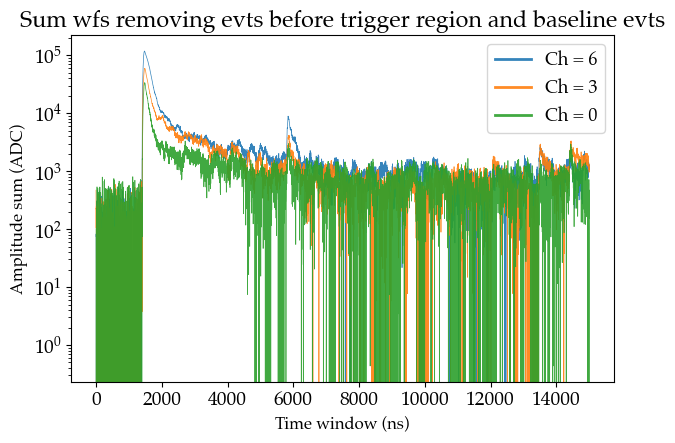

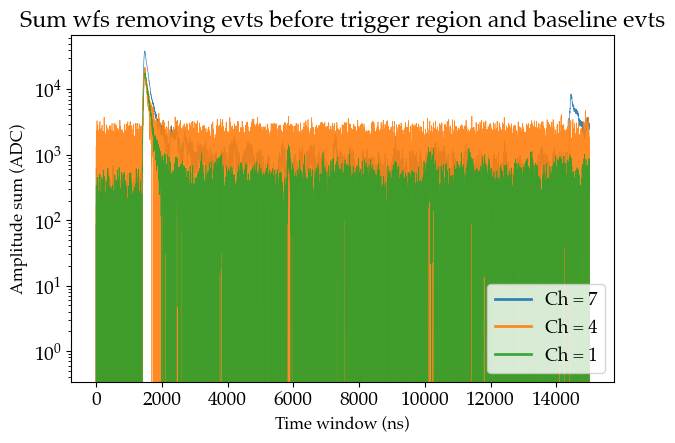

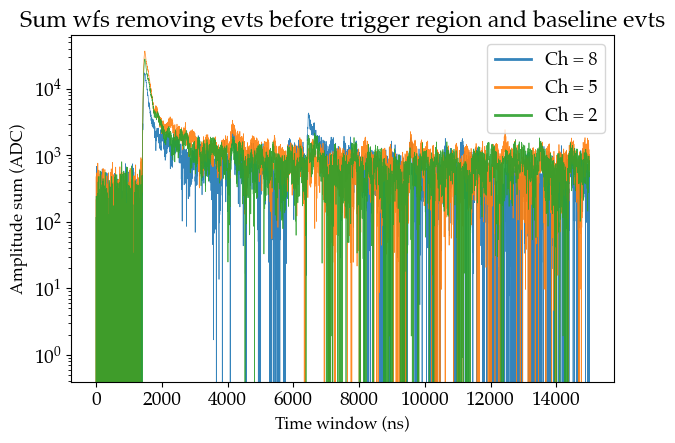

In [10]:
for some_chs in [[6, 3, 0], [7, 4, 1], [8, 5, 2]]:
    plt.figure(figsize=(7, 4.5))
    for ch in some_chs:
        all_wfs          = np.array(RawTree[f'chan{ch}/rdigi'].array())
        all_wfs_rem_bckg = np.array([wf for wf in all_wfs          if np.std(wf[:650])<12]) ## Way to remove bckg before the trigger time
        all_wfs_rem_bsl  = np.array([wf for wf in all_wfs_rem_bckg if np.std(wf)      >12]) ## Way to remove baseline events
        subt_wfs         = pf.subtract_baseline(all_wfs_rem_bsl, mode=False, wf_range_bsl=(0, 650))
        sum_wfs          = np.sum(subt_wfs, axis=0)

        plt.plot(2*np.arange(len(sum_wfs)), sum_wfs, linewidth=0.5, label=f'Ch = {ch}', alpha=0.9)
    plt.title('Sum wfs removing evts before trigger region and baseline evts')
    plt.xlabel('Time window (ns)',    fontsize=12)
    plt.ylabel('Amplitude sum (ADC)', fontsize=12)
    plt.yscale('log')
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
    plt.plot

## Compute and subtract baseline

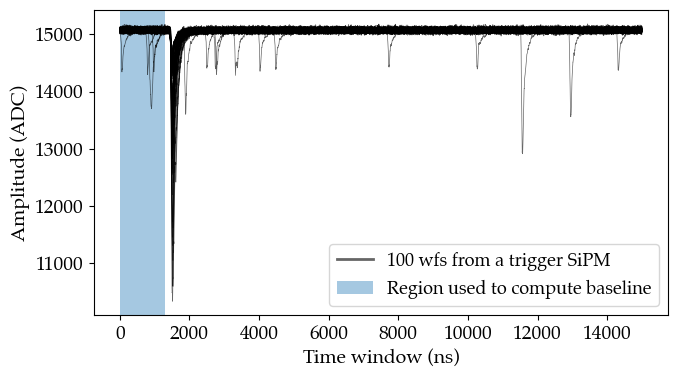

In [11]:
### Region used to compute baseline (using trigger SiPMs)

sel_ch = 9
wfs    = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[:100]
fig    = plt.figure(figsize=(7, 4))
for i, wf in enumerate(wfs):
    if i==0:
        plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5, color='k', alpha=0.6, label='100 wfs from a trigger SiPM')
        plt.axvspan(0, 1300, alpha=0.4, label='Region used to compute baseline')
    else:
        plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5, color='k', alpha=0.6)
        
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADC)',  fontsize=14)
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/Baseline_region.pdf', bbox_inches='tight')
plt.show()

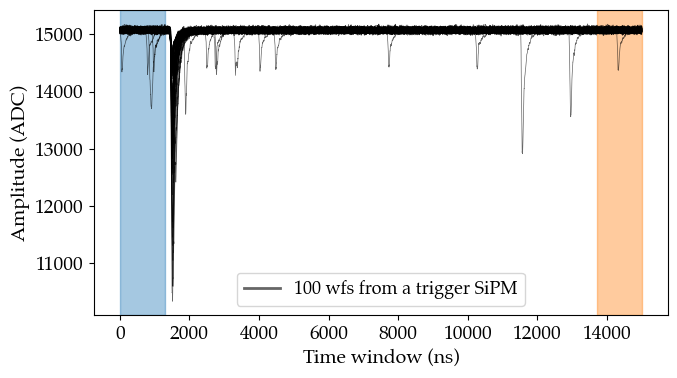

In [12]:
sel_ch = 9
wfs    = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[:100]
fig    = plt.figure(figsize=(7, 4))
for i, wf in enumerate(wfs):
    if i==0:
        plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5, color='k', alpha=0.6, label='100 wfs from a trigger SiPM')
        plt.axvspan(0,           1300, alpha=0.4, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
        plt.axvspan(15000-1300, 15000, alpha=0.4, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][1])
    else:
        plt.plot(2*np.arange(len(wf)), wf, linewidth=0.5, color='k', alpha=0.6)
        
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADC)',  fontsize=14)
    leg = plt.legend(fontsize=13)
    for line in leg.get_lines():
        line.set_linewidth(2)
plt.tight_layout()
plt.show()

#### Baseline subtraction using the mean

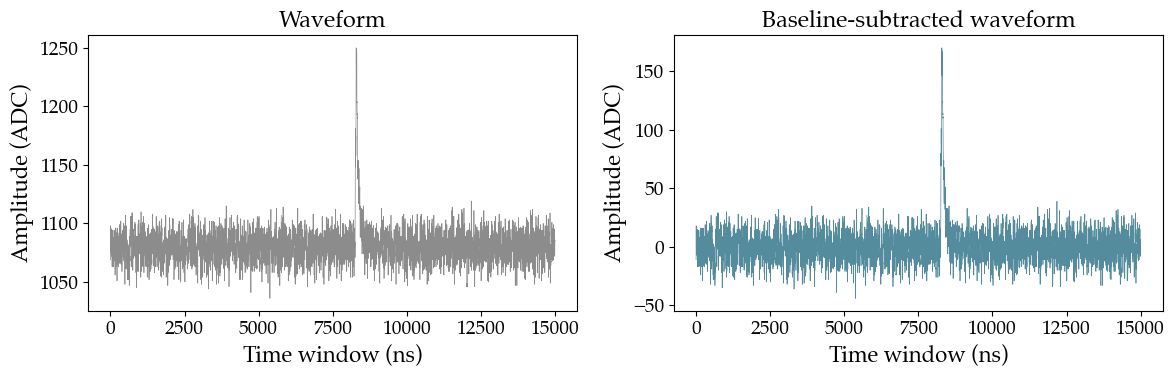

In [13]:
sel_ch     = 0
sel_evt    = 15
one_wf_ch  = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax,wf,col,lab) in enumerate(zip(axs,[one_wf_ch,subt_wf_ch],['grey', fav_col],['Waveform','Baseline-subtracted waveform'])):
    ax.plot(2*np.arange(len(wf)),  wf,  linewidth=0.5, color=col, alpha=0.9)
    ax.set_xlabel('Time window (ns)', fontsize=16)
    ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
    ax.set_title(lab)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/Baseline_subtraction_wf.pdf', bbox_inches='tight')
plt.show()

## Apply the Savinsky-Golay filter to remove the noise

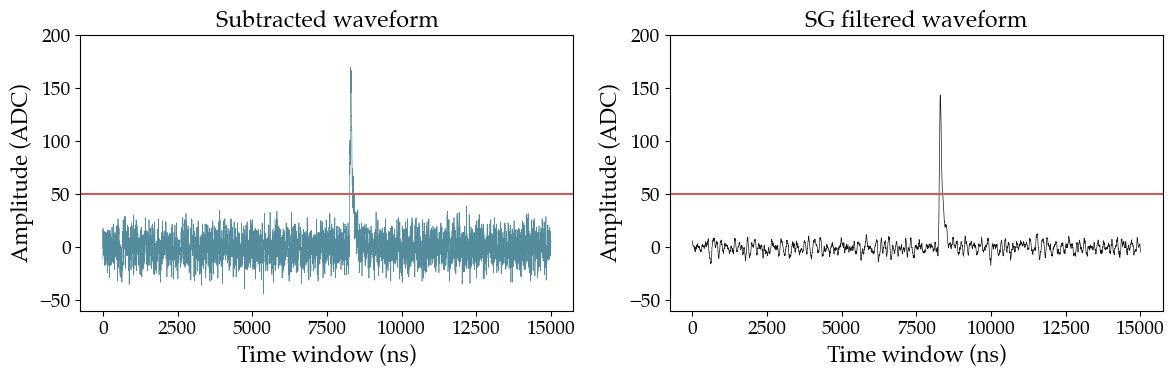

In [14]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax,wf,col,lab) in enumerate(zip(axs,[subt_wf_ch,filt_swf_ch],[fav_col,'k'],['Subtracted waveform', 'SG filtered waveform'])):
    ax.plot(2*np.arange(len(wf)),  wf,  linewidth=0.5, color=col, alpha=0.9)
    ax.axhline(y=sel_thr, color='indianred')
    ax.set_xlabel('Time window (ns)', fontsize=16)
    ax.set_ylabel('Amplitude (ADC)',  fontsize=16)
    ax.set_title(lab)
    ax.set_ylim(-60, 200)
plt.tight_layout()
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/SF_filter_wf.pdf', bbox_inches='tight')
plt.show()

## Noise suppression

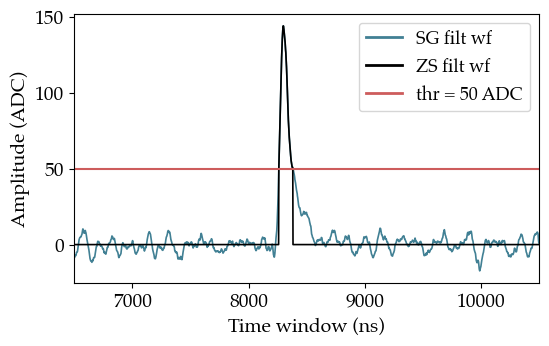

In [15]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(filt_swf_ch)), filt_swf_ch, linewidth=1.2, color=fav_col, label='SG filt wf')
plt.plot(2*np.arange(len(zs_filt_wf)),  zs_filt_wf,  linewidth=1.2, color='k',     label='ZS filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(6500, 10500)
leg = plt.legend(fontsize=13)
for line in leg.get_lines():
    line.set_linewidth(2)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform.pdf', bbox_inches='tight')
plt.show()

## Get peaks abobe threshold using peakutils:

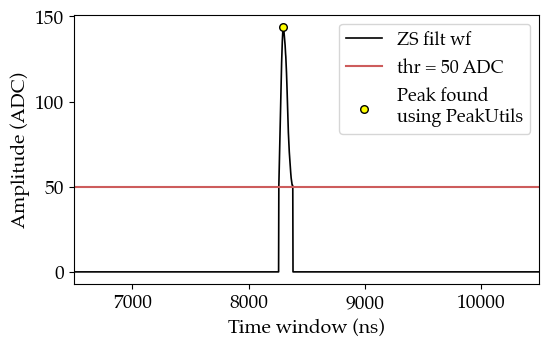

In [16]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(6, 3.5))
plt.plot(2*np.arange(len(zs_filt_wf)),  zs_filt_wf,  linewidth=1.2, color='k', label='ZS filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(6500, 10500)
plt.legend(fontsize=13)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform_peaks.pdf', bbox_inches='tight')
plt.show()

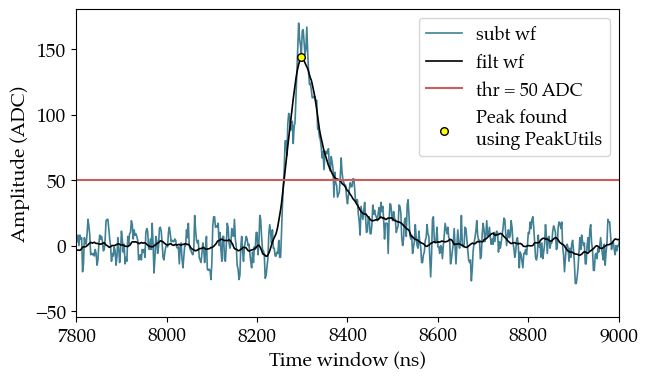

In [22]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
filt_swf_ch = savgol_filter(subt_wf_ch, window_length=50, polyorder=3)
zs_filt_wf  = pf.noise_suppression(filt_swf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(7, 4))
plt.plot(2*np.arange(len(subt_wf_ch)),  subt_wf_ch,  lw=1.2, color=fav_col, label='subt wf')
plt.plot(2*np.arange(len(filt_swf_ch)), filt_swf_ch, lw=1.2, color='k', label='filt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(7800, 9000)
plt.legend(fontsize=13)
#plt.savefig('/Users/romoluque_c/Repositories/BACON_romo/analysis_documentation_run3/images/ZS_waveform_peaks.pdf', bbox_inches='tight')
plt.show()

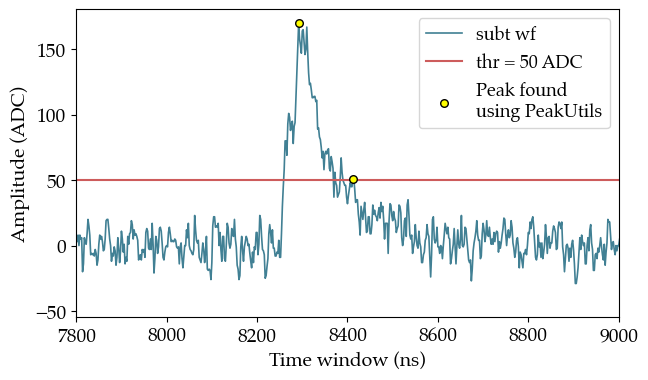

In [25]:
sel_ch      = 0
sel_evt     = 15
sel_thr     = 50 #ADC
one_wf_ch   = np.array(RawTree[f'chan{sel_ch}/rdigi'].array())[sel_evt]
subt_wf_ch  = pf.subtract_baseline(one_wf_ch, mode=False, wf_range_bsl=(0, 650))
zs_filt_wf  = pf.noise_suppression(subt_wf_ch, threshold=sel_thr)
idx_peaks   = pf.get_peaks_peakutils(zs_filt_wf, thres=sel_thr, min_dist=50, thres_abs=True)

plt.figure(figsize=(7, 4))
plt.plot(2*np.arange(len(subt_wf_ch)),  subt_wf_ch,  lw=1.2, color=fav_col, label='subt wf')
plt.axhline(y=sel_thr, color='indianred', label=f'thr = {sel_thr} ADC')
plt.scatter(2*idx_peaks, zs_filt_wf[idx_peaks], color='yellow', edgecolors='black', marker='o', s=30, zorder=2, label=f'Peak found \nusing PeakUtils')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.xlim(7800, 9000)
plt.legend(fontsize=13)
plt.show()